# Libraries & Functions

In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
import time,pandas,numpy,pylab,keras,sklearn
from keras.datasets import mnist
from sklearn import datasets
from scipy import stats
pylab.style.use('seaborn-whitegrid')
import warnings; warnings.filterwarnings("ignore")

In [0]:
from sklearn import svm,manifold,linear_model
from sklearn.semi_supervised import label_propagation
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier,BernoulliRBM

In [0]:
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv1D,Conv2D,MaxPooling1D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import Input,Dense,LSTM,Dropout
from keras.layers import BatchNormalization,Activation,Flatten

In [0]:
def clf_fit_score(clf,x_train,x_test,y_train,y_test):
    clf.fit(x_train,y_train)    
    y_clf_train=clf.predict(x_train)
    y_clf_test=clf.predict(x_test)        
    acc_clf_train=\
    round(accuracy_score(y_train,y_clf_train),6)
    acc_clf_test=\
    round(accuracy_score(y_test,y_clf_test),6)   
    loss_clf_train=\
    round(hamming_loss(y_train,y_clf_train),6)
    loss_clf_test=\
    round(hamming_loss(y_test,y_clf_test),6)   
    return [str(clf),y_clf_train,y_clf_test,
            acc_clf_train,acc_clf_test,
            loss_clf_train,loss_clf_test]

In [0]:
def loss_plot(fit_history,n):
    pylab.figure(figsize=(12,5));
    pylab.plot(fit_history.history['loss'][n:],label='train')
    pylab.plot(fit_history.history['val_loss'][n:],label='test')
    pylab.legend(); pylab.title('Loss Function');  
def acc_plot(fit_history,n):
    pylab.figure(figsize=(12,5))
    pylab.plot(fit_history.history['acc'][n:],label='train')
    pylab.plot(fit_history.history['val_acc'][n:],label='test')
    pylab.legend(); pylab.title('Accuracy'); 

# Datasets

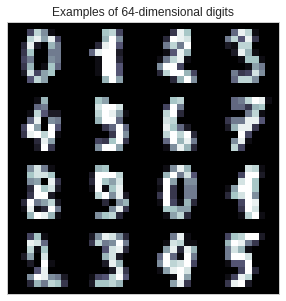

In [8]:
# 8x8 grayscale images; labeled over 10 categories
digits=datasets.load_digits()
X,y=digits.data,digits.target
[x_train1,x_test1,y_train1,y_test1]=\
train_test_split(X,y,test_size=0.2,random_state=1)
n=4; img=numpy.zeros((10*n,10*n))
for i in range(n): 
    for j in range(n): 
      img[(10*i+1):(10*i+9),(10*j+1):(10*j+9)]=\
      X[i*n+j].reshape((8,8))
pylab.figure(figsize=(5,5))
pylab.imshow(img,cmap=pylab.cm.bone)
pylab.title('Examples of 64-dimensional digits')
pylab.xticks([]); pylab.yticks([]); pylab.show()

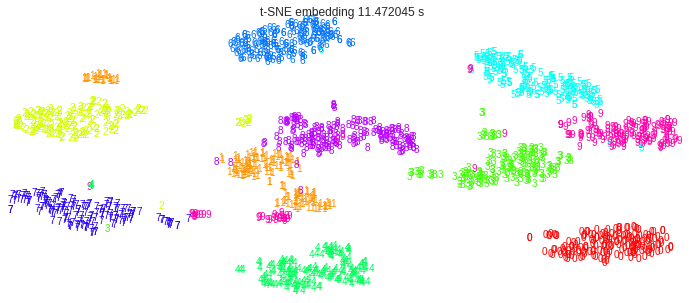

In [11]:
t0=time.time()
X_emb=manifold.TSNE(n_components=2,learning_rate=700.0)\
              .fit_transform(X)
x_min,x_max=numpy.min(X_emb,0),numpy.max(X_emb,0)
X_emb=(X_emb-x_min)/(x_max-x_min)
f,ax=pylab.subplots(1,figsize=(12,5))
pylab.axis("off")
for i in range(X_emb.shape[0]):
    pylab.text(X_emb[i,0],X_emb[i,1],str(y[i]),
               color=pylab.cm.hsv(y[i]/10.))
pylab.title("t-SNE embedding %f s"%(time.time()-t0))
pylab.show()

In [9]:
# 28x28 grayscale images; labeled over 10 categories
(x_train2,y_train2),(x_test2,y_test2)=mnist.load_data()
n=int(len(x_test2)/2)
x_valid2,y_valid2=x_test2[:n],y_test2[:n]
x_test2,y_test2=x_test2[n:],y_test2[n:]
c_y_train2=keras.utils.to_categorical(y_train2,10)
c_y_valid2=keras.utils.to_categorical(y_valid2,10)
c_y_test2=keras.utils.to_categorical(y_test2,10)
x_train2.shape,x_valid2.shape,x_test2.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (5000, 28, 28), (5000, 28, 28))

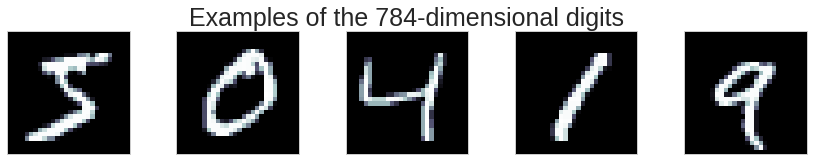

In [10]:
fig,ax=pylab.subplots(figsize=(12,2),nrows=1,
                      ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(5):
    image=x_train2[i].reshape(28,28)
    ax[i].imshow(image,cmap=pylab.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
pylab.tight_layout(); pylab.gcf()
ax[2].set_title('Examples of the 784-dimensional digits',
                fontsize=25);

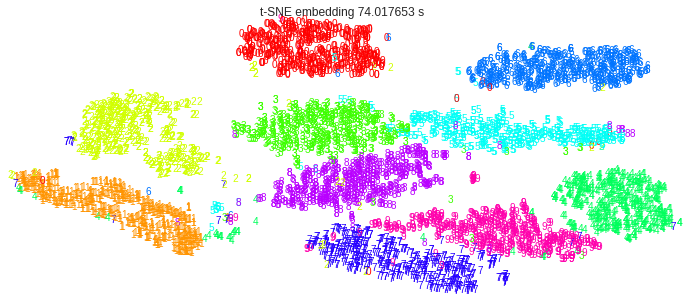

In [27]:
t0=time.time()
X_emb=manifold.TSNE(n_components=2,learning_rate=700.0)\
              .fit_transform(x_test2.reshape(-1,784))
x_min,x_max=numpy.min(X_emb,0),numpy.max(X_emb,0)
X_emb=(X_emb-x_min)/(x_max-x_min)
f,ax=pylab.subplots(1,figsize=(12,5))
pylab.axis("off")
for i in range(X_emb.shape[0]):
    pylab.text(X_emb[i,0],X_emb[i,1],str(y_test2[i]),
               color=pylab.cm.hsv(y_test2[i]/10.))
pylab.title("t-SNE embedding %f s"%(time.time()-t0))
pylab.show()

# Classification 1

In [0]:
clf=[LogisticRegressionCV(solver='liblinear',
                          multi_class='ovr'),
     svm.SVC(gamma='scale',C=10.0,kernel='poly'),
     KNeighborsClassifier(),
     RadiusNeighborsClassifier(radius=30),
     RandomForestClassifier(n_estimators=64,
                            max_depth=11)]

In [0]:
 result=[]
 for c in clf:
   result.append(clf_fit_score(c,x_train1,x_test1,
                               y_train1,y_test1))

In [14]:
for i in range(5):
    print(result[i][0])
    print('accuracy train/test: %s'%result[i][3:5])
    print('loss train/test: %s'%result[i][5:7])
    print(80*'=')

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)
accuracy train/test: [0.98469, 0.972222]
loss train/test: [0.01531, 0.027778]
SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
accuracy train/test: [1.0, 0.986111]
loss train/test: [0.0, 0.013889]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
accuracy train/test: [0.98817, 0.994444]
loss train/te

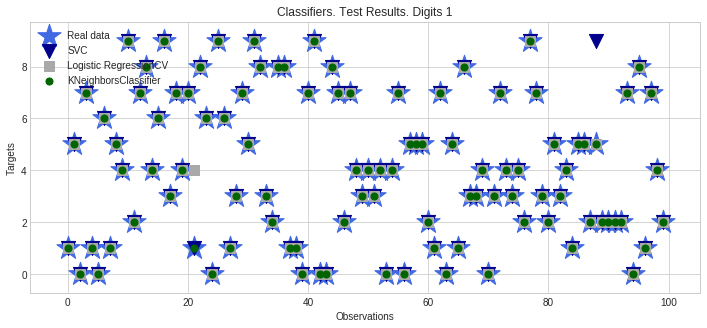

In [15]:
pylab.figure(figsize=(12,5)); n=100; x=range(n)
pylab.scatter(x,y_test1[:n],marker='*',s=600,
              color='royalblue',label='Real data')
pylab.scatter(x,result[1][2][:n],marker='v',s=200,
              color='darkblue',label='SVC')
pylab.scatter(x,result[0][2][:n],marker='s',s=100,
              color='darkgrey',label='Logistic RegressionCV')
pylab.scatter(x,result[2][2][:n],marker='o',s=50,
              color='darkgreen',label='KNeighborsClassifier')
pylab.xlabel('Observations'); pylab.ylabel('Targets')
pylab.title('Classifiers. Test Results. Digits 1')
pylab.legend(loc=2,fontsize=10); pylab.show()

In [16]:
nn_clf1=MLPClassifier(hidden_layer_sizes=(512,),max_iter=70,
                      solver='sgd',verbose=1,
                      random_state=1,learning_rate_init=.01)
nn_clf1.fit(x_train1,y_train1)
[nn_clf1.score(x_train1,y_train1),
 nn_clf1.score(x_test1,y_test1)]

Iteration 1, loss = 8.00530122
Iteration 2, loss = 0.40345160
Iteration 3, loss = 0.18567301
Iteration 4, loss = 0.11457804
Iteration 5, loss = 0.08503822
Iteration 6, loss = 0.07348423
Iteration 7, loss = 0.05662412
Iteration 8, loss = 0.05273783
Iteration 9, loss = 0.04391314
Iteration 10, loss = 0.03620788
Iteration 11, loss = 0.03801262
Iteration 12, loss = 0.02911084
Iteration 13, loss = 0.02615359
Iteration 14, loss = 0.02538807
Iteration 15, loss = 0.02224096
Iteration 16, loss = 0.02030931
Iteration 17, loss = 0.01865935
Iteration 18, loss = 0.01775010
Iteration 19, loss = 0.01648355
Iteration 20, loss = 0.01585530
Iteration 21, loss = 0.01461249
Iteration 22, loss = 0.01422504
Iteration 23, loss = 0.01337695
Iteration 24, loss = 0.01259988
Iteration 25, loss = 0.01190659
Iteration 26, loss = 0.01152053
Iteration 27, loss = 0.01214406
Iteration 28, loss = 0.01080019
Iteration 29, loss = 0.01008233
Iteration 30, loss = 0.00954526
Iteration 31, loss = 0.00908236
Iteration 32, los

[1.0, 0.9916666666666667]

In [18]:
print("MLPClassifier:\n%s\n"\
      %(classification_report(y_test1,
                              nn_clf1.predict(x_test1))))

MLPClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      0.97      0.99        35
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00        38
           5       0.97      1.00      0.98        30
           6       0.97      1.00      0.99        37
           7       1.00      0.97      0.99        37
           8       1.00      1.00      1.00        29
           9       0.97      0.97      0.97        34

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360




In [19]:
x_train1_scaled=\
(x_train1-numpy.min(x_train1,0))/(numpy.max(x_train1,0)+0.0001)
x_test1_scaled=\
(x_test1-numpy.min(x_test1,0))/(numpy.max(x_test1,0)+0.0001)
logistic=LogisticRegression(solver='liblinear',multi_class='ovr',
                            max_iter=50,tol=0.0001,C=5000.0)
brbm=BernoulliRBM(random_state=0,verbose=False)
brbm.learning_rate,brbm.n_iter,brbm.n_components=0.05,50,64
nn_clf2=Pipeline(steps=[('brbm',brbm),('logistic',logistic)])
nn_clf2.fit(x_train1_scaled,y_train1)

Pipeline(memory=None,
         steps=[('brbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.05,
                              n_components=64, n_iter=50, random_state=0,
                              verbose=False)),
                ('logistic',
                 LogisticRegression(C=5000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [21]:
print("Logistic regression using BRBM features:\n%s\n"\
      %(classification_report(y_test1,
                              nn_clf2.predict(x_test1_scaled))))

Logistic regression using BRBM features:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.97      0.97      0.97        35
           2       0.97      0.97      0.97        36
           3       0.95      1.00      0.98        41
           4       0.97      0.97      0.97        38
           5       0.94      0.97      0.95        30
           6       1.00      1.00      1.00        37
           7       0.94      0.89      0.92        37
           8       0.90      0.90      0.90        29
           9       0.97      0.97      0.97        34

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360




# Classification 2

In [0]:
n_total=42000; n_labeled=14000
X2=numpy.copy(x_train2.reshape(-1,784)[:n_total])
y2=numpy.copy(y_train2[:n_total])
y[n_labeled:]=-1
lp_model=label_propagation\
         .LabelSpreading(kernel='knn',n_neighbors=10,
                         n_jobs=-1,max_iter=200)
lp_model.fit(X2,y2)
predicted_labels=lp_model.transduction_[n_labeled:n_total]
true_labels=y_train2[n_labeled:n_total]

In [37]:
print("Label Spreading: %d labeled & %d unlabeled points (%d total)"%
      (n_labeled,n_total-n_labeled,n_total))
print(classification_report(true_labels,predicted_labels))
print("Confusion matrix")
print(confusion_matrix(true_labels,predicted_labels,
                       labels=lp_model.classes_))
predict_entropies=\
stats.distributions.entropy(lp_model.label_distributions_.T)
uncertainty_index=numpy.argsort(predict_entropies)[-10:]

Label Spreading: 14000 labeled & 28000 unlabeled points (42000 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2738
           1       1.00      1.00      1.00      3226
           2       1.00      1.00      1.00      2780
           3       1.00      1.00      1.00      2814
           4       1.00      1.00      1.00      2730
           5       1.00      1.00      1.00      2558
           6       1.00      1.00      1.00      2787
           7       1.00      1.00      1.00      2847
           8       1.00      1.00      1.00      2707
           9       1.00      1.00      1.00      2813

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000

Confusion matrix
[[2738    0    0    0    0    0    0    0    0    0]
 [   0 3226    0    0    0    0    0    0    0    0]
 [   2    2 2776    0    0    0    0    0    0  

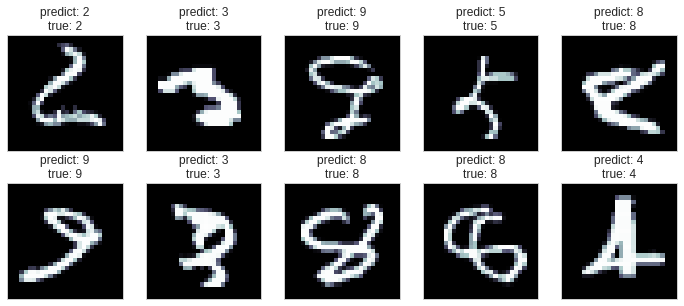

In [39]:
fig=pylab.figure(figsize=(12,5))
for index,image_index in enumerate(uncertainty_index):
    image=x_train2[image_index]
    sub=fig.add_subplot(2,5,index+1)
    sub.imshow(image,cmap=pylab.cm.bone)
    pylab.xticks([]); pylab.yticks([])
    sub.set_title('predict: %i\ntrue: %i'%(
        lp_model.transduction_[image_index],
        y_train2[image_index]))

0.9722 0.9472


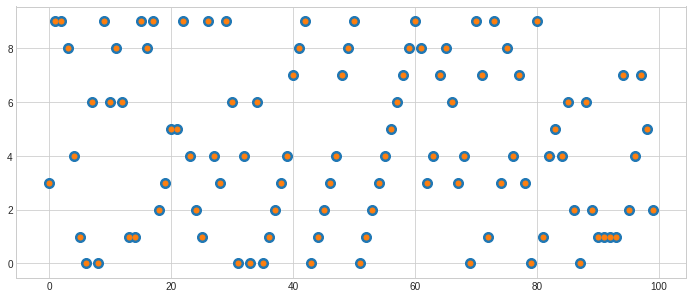

In [20]:
clf=MLPClassifier(hidden_layer_sizes=(256,),
                  max_iter=7,solver='adam',
                  verbose=0,random_state=1,
                  learning_rate_init=.001)
clf.fit(x_train2.reshape(-1,784),y_train2)
print(clf.score(x_test2.reshape(-1,784),y_test2),
      clf.score(x_valid2.reshape(-1,784),y_valid2))
y_test2_predictions=clf.predict(x_test2.reshape(-1,784))
pylab.figure(figsize=(12,5))
pylab.scatter(range(100),y_test2[:100],s=100)
pylab.scatter(range(100),y_test2_predictions[:100],s=25)
pylab.show()

Iteration 1, loss = inf
Iteration 2, loss = 0.48803416
Iteration 3, loss = 0.35833288
Iteration 4, loss = 0.31011372
Iteration 5, loss = 0.27420066
Iteration 6, loss = 0.25291703
Iteration 7, loss = 0.23781368
Iteration 8, loss = 0.22424604
Iteration 9, loss = 0.21398827
Iteration 10, loss = 0.20528451
Iteration 11, loss = 0.19849473
Iteration 12, loss = 0.19367508
Iteration 13, loss = 0.18650326
Iteration 14, loss = 0.17980426
Iteration 15, loss = 0.17376308
Iteration 16, loss = 0.17071259
Iteration 17, loss = 0.16507464
Iteration 18, loss = 0.16209422
Iteration 19, loss = 0.15845685
Iteration 20, loss = 0.15771982
Iteration 21, loss = 0.15238208
Iteration 22, loss = 0.14897335
Iteration 23, loss = 0.14504865
Iteration 24, loss = 0.14445808
Iteration 25, loss = 0.14088064
Iteration 26, loss = 0.13664035
Iteration 27, loss = 0.13755860
Iteration 28, loss = 0.13516427
Iteration 29, loss = 0.13197702
Iteration 30, loss = 0.13286604
Iteration 31, loss = 0.13176581
Iteration 32, loss = 0.1

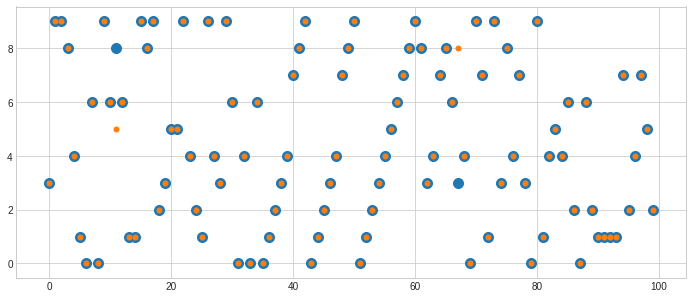

In [30]:
clf=MLPClassifier(hidden_layer_sizes=(196,),max_iter=100,alpha=1e-4,
                  solver='sgd',verbose=2, tol=1e-4,random_state=1,
                  learning_rate_init=1e-3)
clf.fit(x_train2.reshape(-1,784),y_train2)
print(clf.score(x_test2.reshape(-1,784),y_test2),
      clf.score(x_valid2.reshape(-1,784),y_valid2))
y_test2_predictions=clf.predict(x_test2.reshape(-1,784))
pylab.figure(figsize=(12,5))
pylab.scatter(range(100),y_test2[:100],s=100)
pylab.scatter(range(100),y_test2_predictions[:100],s=25)
pylab.show()

In [22]:
def model():
    model=Sequential()    
    model.add(Dense(32,activation='relu',input_shape=(784,)))
    model.add(Dropout(rate=0.1))    
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(rate=0.1))    
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model=model(); fw='weights.best.model.hdf5'
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
checkpointer=keras.callbacks.ModelCheckpoint(filepath=fw,save_best_only=True)
lr_reduction=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                               patience=5,factor=0.5)
history=model.fit(x_train2.reshape(-1,784),c_y_train2, 
                  validation_data=(x_valid2.reshape(-1,784),c_y_valid2),
                  epochs=100,batch_size=128,verbose=0,
                  callbacks=[early_stopping,checkpointer,lr_reduction]);


Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


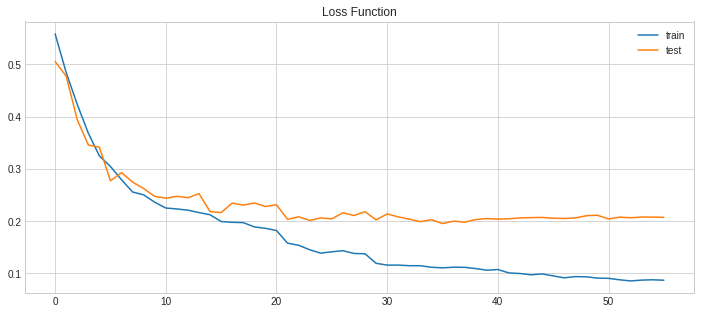

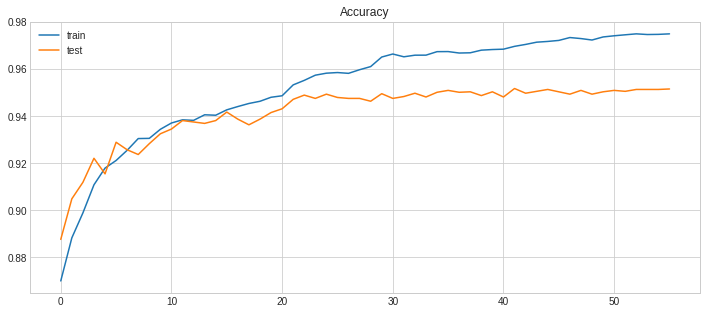

In [23]:
loss_plot(history,2); acc_plot(history,2)

5000/5000 [==============================] - 0s 44us/step


[0.11029383971691131, 0.9714]

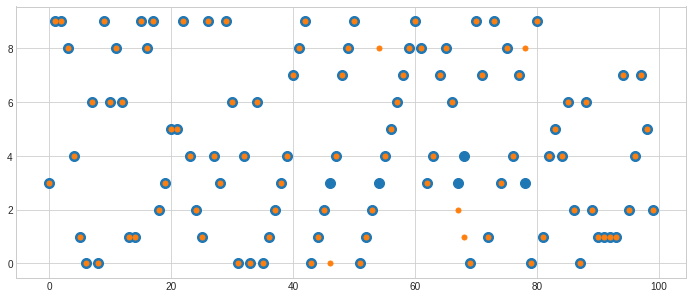

In [24]:
model.load_weights(fw)
y_test2_predictions=model.predict_classes(x_test2.reshape(-1,784))
pylab.figure(figsize=(12,5))
pylab.scatter(range(100),y_test2[:100],s=100)
pylab.scatter(range(100),y_test2_predictions[:100],s=25)
model.evaluate(x_test2.reshape(-1,784),c_y_test2)

In [43]:
def model():
    model_input=Input(shape=(28,28,1))
    x=BatchNormalization()(model_input)   
#    x=Conv2D(28,(5,5),padding='same')(x)
#    x=LeakyReLU(alpha=0.02)(x)
#    x=MaxPooling2D(pool_size=(2, 2))(x)
#    x=Dropout(0.25)(x)   
    x=Conv2D(28,(5,5),padding='same')(x)
    x=LeakyReLU(alpha=0.02)(x)
    x=MaxPooling2D(strides=(2,2))(x)
    x=Dropout(0.25)(x)    
    x=Conv2D(128,(5,5))(x)
    x=LeakyReLU(alpha=0.02)(x)
    x=MaxPooling2D(strides=(2,2))(x)
    x=Dropout(0.25)(x) 
    x=GlobalMaxPooling2D()(x)  
    x=Dense(512)(x)
    x=LeakyReLU(alpha=0.02)(x)
    x=Dropout(0.5)(x)   
    y=Dense(10,activation='softmax')(x)   
    model=Model(input=model_input,output=y)    
#    optimizer=RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.0)   
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
model=model(); fw='weights.best.model.hdf5'
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
checkpointer=keras.callbacks.ModelCheckpoint(filepath=fw,save_best_only=True)
lr_reduction=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                               patience=5,factor=.75,
                                               min_lr=.000001)
history=model.fit(x_train2.reshape(-1,28,28,1),c_y_train2, 
                  validation_data=(x_valid2.reshape(-1,28,28,1),c_y_valid2),
                  epochs=100,batch_size=128,verbose=2,
                  callbacks=[early_stopping,checkpointer,lr_reduction]);   

Train on 60000 samples, validate on 5000 samples
Epoch 1/100
 - 10s - loss: 0.2919 - acc: 0.9050 - val_loss: 0.0572 - val_acc: 0.9832
Epoch 2/100
 - 4s - loss: 0.0763 - acc: 0.9762 - val_loss: 0.0573 - val_acc: 0.9820
Epoch 3/100
 - 4s - loss: 0.0608 - acc: 0.9813 - val_loss: 0.0409 - val_acc: 0.9876
Epoch 4/100
 - 4s - loss: 0.0528 - acc: 0.9840 - val_loss: 0.0373 - val_acc: 0.9888
Epoch 5/100
 - 4s - loss: 0.0455 - acc: 0.9858 - val_loss: 0.0462 - val_acc: 0.9830
Epoch 6/100
 - 4s - loss: 0.0441 - acc: 0.9866 - val_loss: 0.0489 - val_acc: 0.9838
Epoch 7/100
 - 4s - loss: 0.0415 - acc: 0.9870 - val_loss: 0.0468 - val_acc: 0.9858
Epoch 8/100
 - 4s - loss: 0.0380 - acc: 0.9881 - val_loss: 0.0304 - val_acc: 0.9890
Epoch 9/100
 - 4s - loss: 0.0363 - acc: 0.9891 - val_loss: 0.0354 - val_acc: 0.9872
Epoch 10/100
 - 4s - loss: 0.0353 - acc: 0.9889 - val_loss: 0.0371 - val_acc: 0.9866
Epoch 11/100
 - 4s - loss: 0.0303 - acc: 0.9903 - val_loss: 0.0354 - val_acc: 0.9882
Epoch 12/100
 - 4s - los

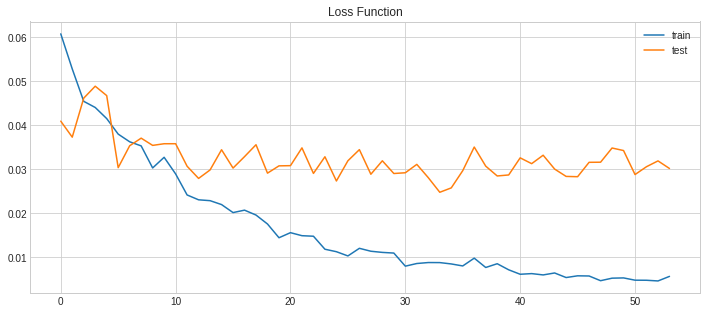

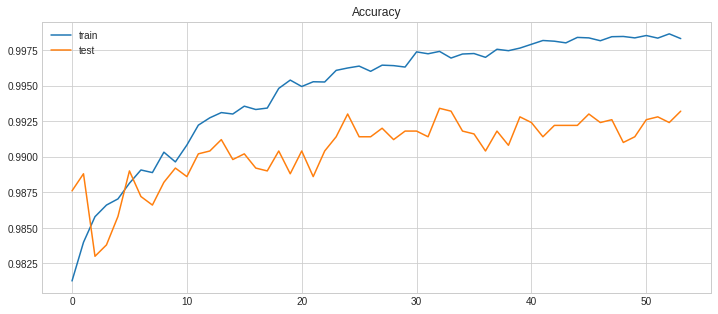

In [44]:
loss_plot(history,2); acc_plot(history,2)

5000/5000 [==============================] - 0s 61us/step


[0.009555699665227894, 0.9976]

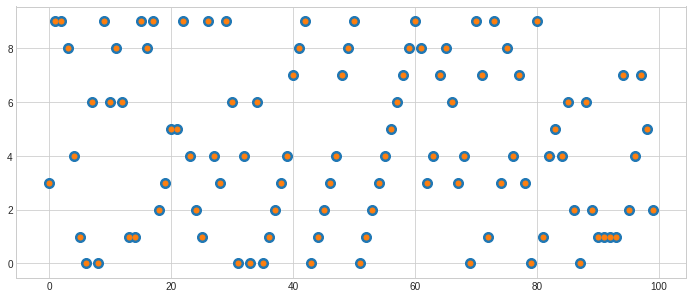

In [47]:
model.load_weights(fw)
y_test2_predictions=\
model.predict(x_test2.reshape(-1,28,28,1))\
.argmax(axis=-1)
pylab.figure(figsize=(12,5))
pylab.scatter(range(100),y_test2[:100],s=100)
pylab.scatter(range(100),y_test2_predictions[:100],s=25)
model.evaluate(x_test2.reshape(-1,28,28,1),c_y_test2)

In [0]:
steps,epochs=1000,50
data_generator=\
ImageDataGenerator(zoom_range=0.2,shear_range=0.2, 
                   rotation_range=20,width_shift_range=0.2,
                   height_shift_range=0.2)
data_generator.fit(x_train2.reshape(-1,28,28,1))

In [52]:
history=model.\
fit_generator(data_generator.flow(x_train2.reshape(-1,28,28,1),
                                  c_y_train2,batch_size=128),
              steps_per_epoch=steps,epochs=epochs,verbose=2,
              validation_data=(x_valid2.reshape(-1,28,28,1),c_y_valid2), 
              callbacks=[early_stopping,checkpointer,lr_reduction])

Epoch 1/50
 - 31s - loss: 0.1294 - acc: 0.9611 - val_loss: 0.0192 - val_acc: 0.9934
Epoch 2/50
 - 31s - loss: 0.0975 - acc: 0.9704 - val_loss: 0.0187 - val_acc: 0.9940
Epoch 3/50
 - 32s - loss: 0.0871 - acc: 0.9731 - val_loss: 0.0182 - val_acc: 0.9942
Epoch 4/50
 - 31s - loss: 0.0817 - acc: 0.9745 - val_loss: 0.0184 - val_acc: 0.9936
Epoch 5/50
 - 31s - loss: 0.0781 - acc: 0.9758 - val_loss: 0.0173 - val_acc: 0.9942
Epoch 6/50
 - 31s - loss: 0.0730 - acc: 0.9771 - val_loss: 0.0185 - val_acc: 0.9942
Epoch 7/50
 - 31s - loss: 0.0711 - acc: 0.9784 - val_loss: 0.0173 - val_acc: 0.9948
Epoch 8/50
 - 31s - loss: 0.0701 - acc: 0.9783 - val_loss: 0.0169 - val_acc: 0.9944
Epoch 9/50
 - 31s - loss: 0.0667 - acc: 0.9792 - val_loss: 0.0167 - val_acc: 0.9944
Epoch 10/50
 - 31s - loss: 0.0634 - acc: 0.9802 - val_loss: 0.0169 - val_acc: 0.9944
Epoch 11/50
 - 31s - loss: 0.0639 - acc: 0.9806 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 12/50
 - 31s - loss: 0.0609 - acc: 0.9810 - val_loss: 0.0153 - val_a

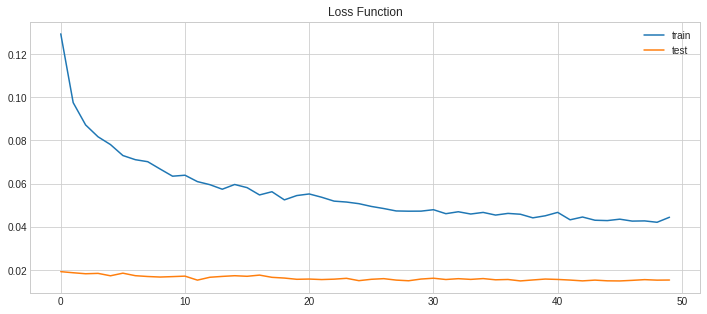

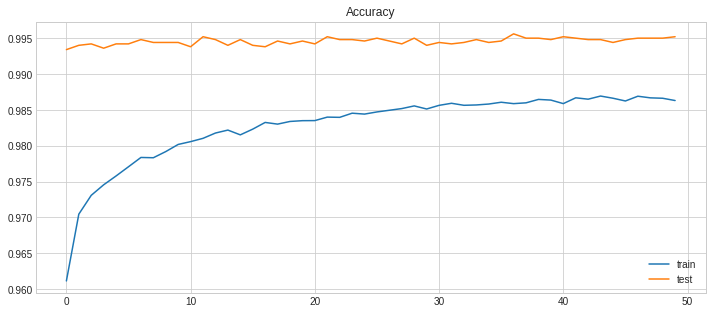

In [53]:
loss_plot(history,0); acc_plot(history,0)

5000/5000 [==============================] - 0s 58us/step


[0.0068270798404679225, 0.9974]

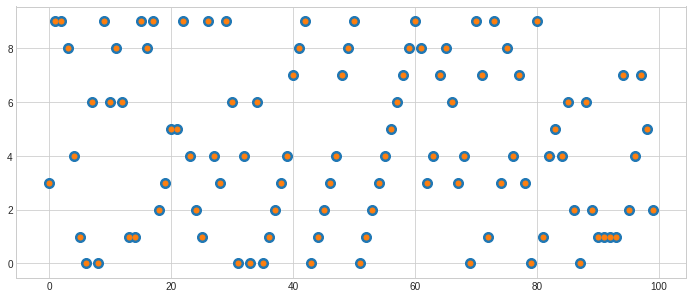

In [54]:
model.load_weights(fw)
y_test2_predictions=\
model.predict(x_test2.reshape(-1,28,28,1))\
.argmax(axis=-1)
pylab.figure(figsize=(12,5))
pylab.scatter(range(100),y_test2[:100],s=100)
pylab.scatter(range(100),y_test2_predictions[:100],s=25)
model.evaluate(x_test2.reshape(-1,28,28,1),c_y_test2)

In [56]:
def model():
    model=Sequential()
    model.add(LSTM(196,return_sequences=True,
                   input_shape=(1,784)))    
    model.add(LSTM(196,return_sequences=True))   
    model.add(LSTM(784))      
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='nadam', metrics=['accuracy'])    
    return model
model=model(); fw='weights.best.model.hdf5'
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
checkpointer=keras.callbacks.ModelCheckpoint(filepath=fw,save_best_only=True)
lr_reduction=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                               patience=5,factor=.75,
                                               min_lr=.000001)
history=model.fit(x_train2.reshape(-1,1,784),c_y_train2, 
                  validation_data=(x_valid2.reshape(-1,1,784),c_y_valid2),
                  epochs=100,batch_size=128,verbose=2,
                  callbacks=[early_stopping,checkpointer,lr_reduction]);

Train on 60000 samples, validate on 5000 samples
Epoch 1/100
 - 9s - loss: 0.5374 - acc: 0.8248 - val_loss: 0.4010 - val_acc: 0.8670
Epoch 2/100
 - 7s - loss: 0.3883 - acc: 0.8710 - val_loss: 0.3882 - val_acc: 0.8756
Epoch 3/100
 - 8s - loss: 0.3328 - acc: 0.8930 - val_loss: 0.3620 - val_acc: 0.8816
Epoch 4/100
 - 7s - loss: 0.2988 - acc: 0.9019 - val_loss: 0.3686 - val_acc: 0.8774
Epoch 5/100
 - 7s - loss: 0.2866 - acc: 0.9052 - val_loss: 0.3577 - val_acc: 0.8826
Epoch 6/100
 - 7s - loss: 0.2508 - acc: 0.9188 - val_loss: 0.3046 - val_acc: 0.8984
Epoch 7/100
 - 7s - loss: 0.2509 - acc: 0.9171 - val_loss: 0.3085 - val_acc: 0.9014
Epoch 8/100
 - 7s - loss: 0.2273 - acc: 0.9258 - val_loss: 0.2902 - val_acc: 0.9046
Epoch 9/100
 - 7s - loss: 0.2227 - acc: 0.9261 - val_loss: 0.2736 - val_acc: 0.9120
Epoch 10/100
 - 7s - loss: 0.2161 - acc: 0.9285 - val_loss: 0.2835 - val_acc: 0.9062
Epoch 11/100
 - 7s - loss: 0.2029 - acc: 0.9319 - val_loss: 0.2548 - val_acc: 0.9208
Epoch 12/100
 - 7s - loss

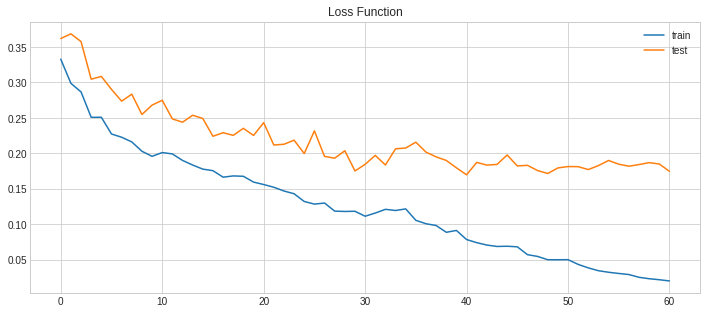

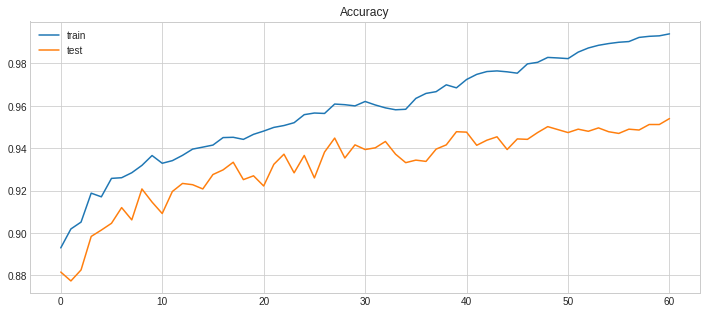

In [57]:
loss_plot(history,2); acc_plot(history,2)

5000/5000 [==============================] - 1s 143us/step


[0.09173460639715195, 0.969]

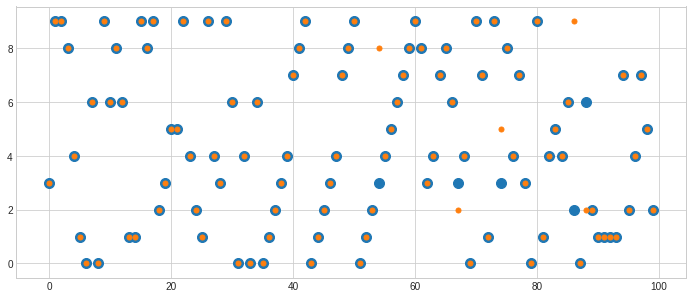

In [58]:
model.load_weights(fw)
y_test2_predictions=\
model.predict(x_test2.reshape(-1,1,784))\
.argmax(axis=-1)
pylab.figure(figsize=(12,5))
pylab.scatter(range(100),y_test2[:100],s=100)
pylab.scatter(range(100),y_test2_predictions[:100],s=25)
model.evaluate(x_test2.reshape(-1,1,784),c_y_test2)